In [ ]:
import timm
import gc
import wandb
from fastai.vision.all import *
from fastai.callback.wandb import *
from utils.core import *

path = Path('/root/.fastai/data/oxford-iiit-pet')
Path.BASE_PATH = path

df = pd.read_csv('pets_sample.csv')

In [ ]:
sweep_cfg = {
    'project': 'my_fastbook',
    'metric': {'name': 'error_rate', 'goal': 'minimize'},
    # 'method': 'random',
    'method': 'bayes',
    'parameters': {
        'epochs': {
            'value': 15
        },
        'pre_size': {
            'value': 160,
        },
        'post_size': {
            'value': 112,
        },
        'pre_bs': {
            'value': 256,
        },
        'post_bs': {
            'value': 192,
        },
        'pre_lr': {
            'min': 1e-3,
            'max': 1e-2
        },
        'pre_epoch': {
            'values': [1,2,3],
        },
        'post_lr': {
            'min': 1e-3,
            'max': 1e-2
        },
        'post_div': {
            'min': 50,
            'max': 250
        }
    }
   
}

sweep_cfg2 = {
    'project': 'my_fastbook',
    'metric': {'name': 'best_value', 'goal': 'minimize'},
    # 'metric': {'name': 'error_rate', 'goal': 'minimize'},
    # 'method': 'random',
    'method': 'bayes',
    'parameters': {
        'arch': {
            'value': 'convnext_tiny_in22k_stage0.pth'
        },
        'epochs': {
            'value': 15
        },
        'pre_size': {
            'value': 240,
        },
        'post_size': {
            'value': 168,
        },
        'pre_bs': {
            'value': 192,
        },
        'post_bs': {
            'value': 96,
        },
        'pre_lr': {
            'min': 5e-4,
            'max': 5e-3
        },
        'pre_epoch': {
            'values': [0,1,2],
        },
        'post_lr': {
            'min': 5e-4,
            'max': 5e-3
        },
        'post_div': {
            'min': 50,
            'max': 250
        }
    }
   
}

def get_dls(item_tfms=Resize(160), 
            batch_tfms=aug_transforms(size=112), 
            valid_pct=.4,
            bs=64):
    return ImageDataLoaders.from_df(df, path/'images',
                                    splitter=RandomSplitter(seed=42), 
                                    valid_pct=valid_pct,
                                    item_tfms=item_tfms,
                                    batch_tfms=batch_tfms,
                                    seed=42,
                                    bs=bs)

def get_learn():
        return vision_learner(get_dls(), arch, 
                           metrics=error_rate)

arch = 'convnext_tiny_in22k'

def trainer():
    wandb.init()
    set_seed(2022, True)
    dls = get_dls(item_tfms=Resize(wandb.config.pre_size),
                  batch_tfms=aug_transforms(size=wandb.config.post_size),
                  bs=wandb.config.pre_bs)
    learn = vision_learner(get_dls(), arch, 
                           cbs=[WandbCallback()], 
                           metrics=error_rate)
    learn.fit_one_cycle(wandb.config.pre_epoch, lr_max=wandb.config.pre_lr)
    learn.unfreeze()
    learn.dls = get_dls(item_tfms=Resize(wandb.config.pre_size),
                  batch_tfms=aug_transforms(size=wandb.config.post_size),
                  bs=wandb.config.post_bs)
    learn.fit_one_cycle(wandb.config.epochs - wandb.config.pre_epoch, lr_max=(wandb.config.post_lr/wandb.config.post_div, wandb.config.post_lr))
    learn = None
    dls = None
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()
    
class BestValueCallback(TrackerCallback):
    def after_epoch(self):
        super().after_epoch()
        if self.wandb: wandb.log({'best_value':self.best})
        
def trainer2(cfg={}):
    wandb.init(config=cfg)
    set_seed(2022, True)
    learn = load_learner(wandb.config.arch)
    learn.add_cbs([
        BestValueCallback(monitor='error_rate', comp=np.less),
        # SaveModelCallback(monitor='error_rate', comp=np.less),
        # EarlyStoppingCallback(monitor='error_rate', comp=np.less, patience=5)
    ])
    if wandb.config.pre_epoch > 0:
        learn.freeze()
        learn.dls = get_dls(item_tfms=Resize(wandb.config.pre_size),
                      batch_tfms=aug_transforms(size=wandb.config.post_size),
                      bs=wandb.config.pre_bs)
        learn.fit_one_cycle(wandb.config.pre_epoch, lr_max=wandb.config.pre_lr)
        learn.unfreeze()
    learn.dls = get_dls(item_tfms=Resize(wandb.config.pre_size),
                  batch_tfms=aug_transforms(size=wandb.config.post_size),
                  bs=wandb.config.post_bs)
    learn.fit_one_cycle(wandb.config.epochs - wandb.config.pre_epoch, lr_max=(wandb.config.post_lr/wandb.config.post_div, wandb.config.post_lr))
    if cfg != {}: return learn
    learn = None
    dls = None
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()
    


In [ ]:
# cfg = {
#     'project': 'my_fastbook',
#         'epochs': 15,
#         'pre_size': 160,
#         'post_size': 112,
#         'pre_bs': 256,
#         'post_bs': 192,
#         'pre_lr': .009463,
#         'pre_epoch': 2,
#         'post_lr': .005208,
#         'post_div': 115   
# }

cfg = {
    'project': 'my_fastbook',
        'arch': 'convnext_tiny_in22k_stage0.pth',
        'epochs': 15,
        'pre_size': 160,
        'post_size': 112,
        'pre_bs': 256,
        'post_bs': 192,
        'pre_lr': .006337,
        'pre_epoch': 2,
        'post_lr': .008101,
        'post_div': 202   
}

cfg = {
    'project': 'my_fastbook',
    'arch': 'convnext_tiny_in22k_stage0.pth',
    'epochs': 15,
    'pre_size': 160,
    'post_size': 112,
    'pre_bs': 256,
    'post_bs': 192,
    'pre_lr': 1e-3,
    'pre_epoch': 2,
    'post_lr': 1e-3,
    'post_div': 202   
}

def runner(cfg={}):
    wandb.init(config=cfg)
    set_seed(2022, True)
    dls = get_dls(item_tfms=Resize(wandb.config.pre_size),
                  batch_tfms=aug_transforms(size=wandb.config.post_size),
                  bs=wandb.config.pre_bs)
    learn = vision_learner(get_dls(), arch, 
                           cbs=[WandbCallback()], 
                           metrics=error_rate)
    learn.fit_one_cycle(wandb.config.pre_epoch, lr_max=wandb.config.pre_lr)
    learn.unfreeze()
    learn.dls = get_dls(item_tfms=Resize(wandb.config.pre_size),
                  batch_tfms=aug_transforms(size=wandb.config.post_size),
                  bs=wandb.config.post_bs)
    learn.fit_one_cycle(wandb.config.epochs - wandb.config.pre_epoch, lr_max=(wandb.config.post_lr/wandb.config.post_div, wandb.config.post_lr))
    learn.path = Path('.')
    learn.export(learn.arch + '_stage0.pth')
    
    
# trainer2(cfg)

In [ ]:
cfg1 = {
    'project': 'my_fastbook',
        'epochs': 15,
        'pre_size': 240,
        'post_size': 168,
        'pre_bs': 192,
        'post_bs': 96,
        'pre_lr': .001,
        'pre_epoch': 1,
        'post_lr': .002,
        'post_div': 100   
}

def runner1(cfg={}):
    wandb.init(config=cfg)
    set_seed(2022, True)
    learn = load_learner('convnext_tiny_in22k_stage0.pth')
    learn.dls = get_dls(item_tfms=Resize(wandb.config.pre_size),
                  batch_tfms=aug_transforms(size=wandb.config.post_size),
                  bs=wandb.config.pre_bs)
    learn.freeze()
    learn.fit_one_cycle(wandb.config.pre_epoch, lr_max=wandb.config.pre_lr)
    learn.unfreeze()
    learn.dls = get_dls(item_tfms=Resize(wandb.config.pre_size),
                  batch_tfms=aug_transforms(size=wandb.config.post_size),
                  bs=wandb.config.post_bs)
    learn.fit_one_cycle(wandb.config.epochs - wandb.config.pre_epoch, lr_max=(wandb.config.post_lr/wandb.config.post_div, wandb.config.post_lr))
    learn.path = Path('.')
    learn.export(learn.arch + '_stage1.pth')
    
runner1(cfg1)

In [ ]:
def get_full_dls(item_tfms=Resize(160), 
            batch_tfms=aug_transforms(size=112), 
            valid_pct=.2,
            bs=64):
    return ImageDataLoaders.from_name_re('.', fnames=get_image_files(path/'images'), 
                                    pat=r'(.+)_\d+.jpg', 
                                    splitter=RandomSplitter(seed=42), 
                                    valid_pct=valid_pct,
                                    item_tfms=item_tfms,
                                    batch_tfms=batch_tfms,
                                    seed=42,
                                   )

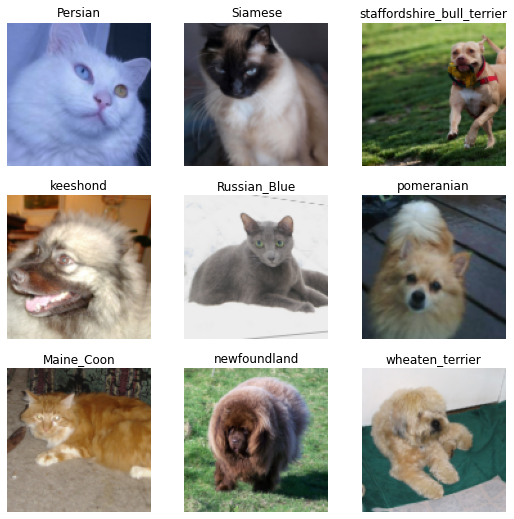

In [ ]:
dls = get_full_dls()
dls.show_batch()

In [ ]:
def trainer3(cfg={}):
    wandb.init(config=cfg)
    set_seed(2022, True)
    learn = load_learner(wandb.config.arch)
    # learn.loss_func = LabelSmoothingCrossEntropyFlat()
    # learn.add_cbs([
    #     # GradientAccumulation(256),
    #     BestValueCallback(monitor='error_rate', comp=np.less),
    #     # SaveModelCallback(monitor='error_rate', comp=np.less),
    #     # EarlyStoppingCallback(monitor='error_rate', comp=np.less, patience=5)
    # ])
    if wandb.config.pre_epoch > 0:
        learn.freeze()
        learn.dls = get_full_dls(item_tfms=Resize(wandb.config.pre_size),
                      batch_tfms=aug_transforms(size=wandb.config.post_size),
                      bs=wandb.config.pre_bs)
        learn.fit_one_cycle(wandb.config.pre_epoch, lr_max=wandb.config.pre_lr)
        learn.unfreeze()
    learn.dls = get_full_dls(item_tfms=Resize(wandb.config.pre_size),
                  batch_tfms=aug_transforms(size=wandb.config.post_size),
                  bs=wandb.config.post_bs)
    learn.fit_one_cycle(wandb.config.epochs - wandb.config.pre_epoch, lr_max=(wandb.config.post_lr/wandb.config.post_div, wandb.config.post_lr))
    if cfg != {}: return learn
    learn = None
    dls = None
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
cfg2 = {
    'project': 'my_fastbook',
    'arch': 'convnext_tiny_in22k_stage1.pth',
    'epochs': 15,
    'pre_size': 320,
    'post_size': 224,
    'pre_bs': 64,
    'post_bs': 32,
    'pre_lr': .001237, #.0009824,
    'pre_epoch': 2,
    'post_lr': .001204, #.001265,
    'post_div': 112 #129
}

learn = trainer3(cfg2)
# learn.path = Path('.')
# learn.export(learn.arch + '_stage1.pth')

wandb: Currently logged in as: mark_b2. Use `wandb login --relogin` to force relogin


epoch,train_loss,valid_loss,error_rate,time
0,0.325728,0.182499,0.050068,04:26
1,0.244047,0.177314,0.051421,04:23


epoch,train_loss,valid_loss,error_rate,time
0,0.203441,0.167320,0.047361,09:41
1,0.181858,0.182500,0.054804,09:39
2,0.176539,0.176475,0.051421,09:38
3,0.150559,0.169336,0.048714,09:37
4,0.123487,0.171934,0.047361,09:37
5,0.100525,0.148357,0.046685,09:37
6,0.075699,0.150906,0.044655,09:38
7,0.065420,0.160108,0.042625,09:37
8,0.055261,0.147619,0.036536,09:38
9,0.048711,0.146297,0.039242,09:39


In [ ]:
learn.export('full_data.pth')

In [ ]:
dls = get_full_dls(item_tfms=Resize(320), batch_tfms=aug_transforms(size=224), bs=24)

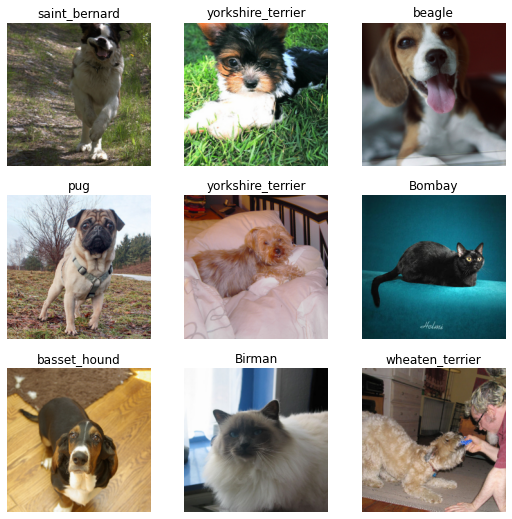

In [ ]:
dls.show_batch()

In [ ]:
learn = load_learner('full_data.pth')
learn.dls = dls

In [ ]:
learn.save('full_data_model.pth')

Path('models/full_data_model.pth.pth')

In [ ]:
learn = vision_learner(dls, arch, metrics=error_rate)
learn.load('full_data_model.pth')

/root/mambaforge/lib/python3.9/site-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


<fastai.learner.Learner>

In [ ]:
# wandb.init(project='my_fastbook', reinit=True)

In [ ]:
# learn.unfreeze()
# learn.fit_one_cycle(15, lr_max=(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.033090,0.145141,0.037212,09:24
1,0.036043,0.141449,0.036536,09:24
2,0.034566,0.144582,0.035183,09:25
3,0.029499,0.144835,0.035859,09:24
4,0.033858,0.142791,0.037889,09:24
5,0.033572,0.143794,0.038566,09:24
6,0.036583,0.141590,0.035859,09:24
7,0.027003,0.140784,0.035183,09:24
8,0.031390,0.143617,0.038566,09:24


KeyboardInterrupt: 

In [ ]:
# pred, targ = learn.get_preds()
pred, targ = learn.tta()
pred.shape, targ.shape

In [ ]:
preds = torch.argmax(pred, axis=-1)
res = (preds != targ).type(torch.FloatTensor).mean(); res

TensorBase(0.0372)

In [ ]:
error_rate(pred,targ)

TensorBase(0.0372)

In [ ]:
res.type(torch.FloatTensor)

TensorBase([0., 0., 0.,  ..., 0., 0., 0.])

In [ ]:
sweep_cfg3 = {
    'project': 'my_fastbook',
    'metric': {'name': 'best_value', 'goal': 'minimize'},
    # 'metric': {'name': 'error_rate', 'goal': 'minimize'},
    'method': 'bayes',
    'parameters': {
        'arch': {
            'value': 'convnext_tiny_in22k_stage1.pth'
        },
        'epochs': {
            'value': 15
        },
        'pre_size': {
            'value': 320,
        },
        'post_size': {
            'value': 224,
        },
        'pre_bs': {
            'value': 64,
        },
        'post_bs': {
            'value': 32,
        },
        'pre_lr': {
            'min': 5e-4,
            'max': 2e-3
        },
        'pre_epoch': {
            'values': [0,1,2],
        },
        'post_lr': {
            'min': 5e-4,
            'max': 2e-3
        },
        'post_div': {
            'min': 50,
            'max': 250
        }
    }
   
}

# sweep_id = wandb.sweep(sweep_cfg3)
sweep_id = 'mybku6li'

In [ ]:
sweep_cfg4 = {
    'project': 'my_fastbook',
    'metric': {'name': 'best_value', 'goal': 'minimize'},
    # 'metric': {'name': 'error_rate', 'goal': 'minimize'},
    'method': 'bayes',
    'parameters': {
        'arch': {
            'value': 'convnext_tiny_in22k_stage0.pth'
        },
        'epochs': {
            'value': 20
        },
        'pre_size': {
            'value': 320,
        },
        'post_size': {
            'value': 224,
        },
        'pre_bs': {
            'value': 64,
        },
        'post_bs': {
            'value': 32,
        },
        'pre_lr': {
            'min': 5e-4,
            'max': 2e-3
        },
        'pre_epoch': {
            'value': 2,
        },
        'post_lr': {
            'min': 5e-4,
            'max': 2e-3
        },
        'post_div': {
            'min': 50,
            'max': 250
        }
    }
   
}

# sweep_id = wandb.sweep(sweep_cfg4)
sweep_id = 'uiujoqnj'

In [ ]:
count = 60

wandb.agent(sweep_id, function=trainer2, count=count, project='my_fastbook')

## TODO Check if `learn.export` save WITH optimizer state?

## Check if GradientAccumulation helps ??
## Check if more fine learning rate splitting helps??
## LabelSmoothing ??

In [ ]:
Learner.export

In [ ]:
res_df = pd.read_csv('results.csv') #.loc[df.stage==0]
by_valid = res_df.sort_values('valid', ascending=True)
by_error = res_df.sort_values('error', ascending=True)

In [ ]:
# df.drop(df.loc[df['div'] > 0].index, inplace=True)
# df

In [ ]:
# df.to_csv('results.csv', index=False)

In [ ]:
by_error.head()

In [ ]:
by_valid.head()

In [ ]:
learn = vision_learner(get_dls(bs=256), arch, metrics=error_rate)
learn.fit_one_cycle(3, lr_max=4e-3)
learn.unfreeze()
learn.dls = get_dls(bs=192)
learn.fit_one_cycle(10, lr_max=(4e-5,4e-3))

In [ ]:
wandb.init(project='fastbook', config=sweep_cfg)
arch = 'convnext_tiny_in22k'
learn = load_learner(arch+'_160_112_3_003_stage0.pth')
learn.unfreeze()
learn.dls = get_dls(bs=wandb.config.post_bs)
learn.add_cb(WandbCallback())
learn.fit_one_cycle(3, lr_max=(4e-5,4e-3))

In [ ]:
learn = vision_learner(get_dls(bs=256), arch, metrics=error_rate)
learn.fit_one_cycle(3, lr_max=2e-3)
learn.unfreeze()
learn.dls = get_dls(bs=196)
learn.fit_one_cycle(10, lr_max=(1e-5,1e-3))

In [ ]:
for lr in np.logspace(-3,-1.5,5):
    lr = float(lr)
    learn = vision_learner(get_dls(bs=256), arch, metrics=error_rate)
    print(lr)
    learn.fit_one_cycle(6, lr_max=lr, pct_start=.99)

In [ ]:
learn = vision_learner(get_dls(bs=256), arch, metrics=error_rate)
learn.fit_one_cycle(6, lr_max=.006)
learn.path = Path('.')
learn.export('convnext_nano_160_112_005_stage0.pth')

In [ ]:
for dev in np.logspace(1,3,5):
    for lr in [1e-3, 2e-3]:
        dev = float(dev)
        learn = load_learner('convnext_nano_160_112_005_stage0.pth')
        learn.dls = get_dls(bs=256)
        print(lr, dev)
        learn.fit_one_cycle(16, lr_max=slice(lr/dev,lr))

In [ ]:
learn = load_learner('convnext_nano_160_112_005_stage0.pth')
learn.dls = get_dls(bs=256)
learn.fit_one_cycle(16, lr_max=(1e-5,1e-3))

In [ ]:
for dev in np.logspace(1,3,5):
    for lr in [1e-3, 2e-3]:
        dev = float(dev)
        learn = load_learner('convnext_nano_160_112_005_stage0.pth')
        learn.dls = get_dls(bs=256)
        print(lr, dev)
        learn.fit_one_cycle(16, lr_max=slice(lr/dev,lr))